# Chapter 4: Tactical portfolio management

### 4.1. How dynamic methods works?
> ###### 4.1.1. Short a stock
> ###### 4.1.2. Momentum factor
> ###### 4.1.3. Rebalancing

### 4.2. Moving average strategy
> ###### 4.2.1. Moving average 
> ###### 4.2.2. Moving average factor
> ###### 4.2.3. Build the strategy

### 4.3. Correlation strategy
> ###### 4.3.1. Correlation
> ###### 4.3.2. Correlation factor
> ###### 4.3.3. Build the strategy

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
plt.style.use('seaborn')
import warnings
warnings.filterwarnings("ignore")

In [2]:
# Importation of data
list_tickers = ["META", "NFLX", "TSLA"]
database = yf.download(list_tickers)

# Take only the adjusted stock price
database = database["Adj Close"]

# Drop missing values
data = database.dropna()

[*********************100%***********************]  3 of 3 completed


### 4.2.1. Moving average

In [3]:
# Create the SMA15 for the stocks
data["SMA15 META"] = data["META"].rolling(15).mean().shift(1)
data["SMA15 NFLX"] = data["NFLX"].rolling(15).mean().shift(1)
data["SMA15 TSLA"] = data["TSLA"].rolling(15).mean().shift(1)

# Create a SMA60
data["SMA60 META"] = data["META"].rolling(60).mean().shift(1)

# Plot the data
print(data)

                  META        NFLX        TSLA  SMA15 META  SMA15 NFLX  \
Date                                                                     
2012-05-18   38.230000    9.994286    1.837333         NaN         NaN   
2012-05-21   34.029999   10.248571    1.918000         NaN         NaN   
2012-05-22   31.000000    9.672857    2.053333         NaN         NaN   
2012-05-23   32.000000   10.272857    2.068000         NaN         NaN   
2012-05-24   33.029999   10.038571    2.018667         NaN         NaN   
...                ...         ...         ...         ...         ...   
2022-11-18  112.050003  287.980011  180.190002  102.222001  281.986001   
2022-11-21  109.860001  285.049988  167.869995  103.078668  281.470001   
2022-11-22  111.440002  286.690002  169.910004  104.192001  281.014667   
2022-11-23  112.239998  291.500000  183.199997  105.274668  281.010667   
2022-11-25  111.410004  285.540009  182.860001  106.721334  282.244000   

            SMA15 TSLA  SMA60 META  


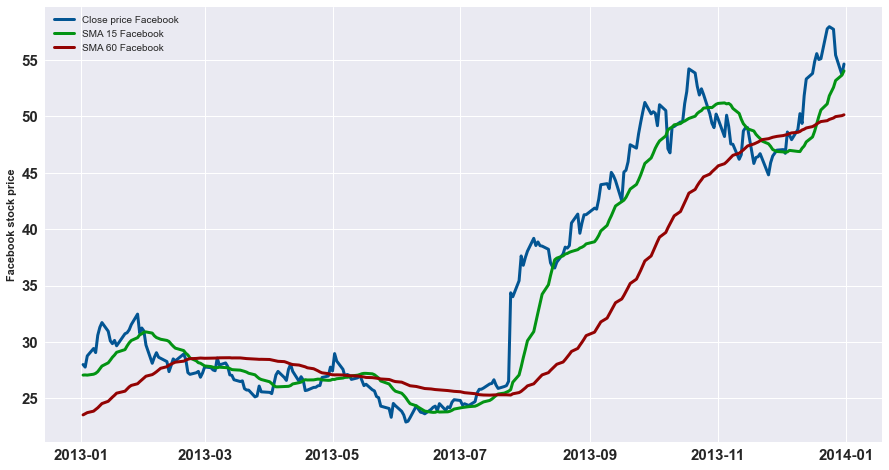

In [4]:
# Plot the CM
plt.figure(figsize=(15,8))
plt.plot(data["META"].loc["2013"], color="#035593", linewidth=3)
plt.plot(data["SMA15 META"].loc["2013"], color="#039313", linewidth=3)
plt.plot(data["SMA60 META"].loc["2013"], color="#930303", linewidth=3)
plt.ylabel("Facebook stock price",fontweight="bold")
plt.legend(["Close price Facebook", "SMA 15 Facebook", "SMA 60 Facebook"])
plt.xticks(size=15,fontweight="bold")
plt.yticks(size=15,fontweight="bold")
plt.show()

<br>

### 4.2.2. Moving average factor

###### From this point the data are monthly and not daily

In [5]:
# We need monthly data now

# Importation of data
list_tickers = ["META", "NFLX", "TSLA"]
database = yf.download(list_tickers, interval="1mo")

# Take only the adjusted stock price
database = database["Adj Close"]

# Drop missing values
data = database.dropna()

# Display the data
data

[*********************100%***********************]  3 of 3 completed


,META,NFLX,TSLA
Date,,,
2012-06-01,31.100000,9.784286,2.086000
2012-07-01,21.709999,8.121429,1.828000
2012-08-01,18.059999,8.531429,1.901333
2012-09-01,21.660000,7.777143,1.952000
2012-10-01,21.110001,11.320000,1.875333
...,...,...,...
2022-08-01,162.929993,223.559998,275.609985
2022-09-01,135.679993,235.440002,265.250000
2022-10-01,93.160004,291.880005,227.539993


In [6]:
# Create the all necessary SMA
list_tickers = ["META", "NFLX", "TSLA"]

# We do a loop to create the SMAs for each asset
for col in list_tickers:
    data[f"pct {col}"] = data[col].pct_change(1)
    data[f"SMA3 {col}"] = data[col].rolling(3).mean().shift(1)
    data[f"SMA12 {col}"] = data[col].rolling(12).mean().shift(1)
    data[f"Momentum factor {col}"] = data[f"SMA3 {col}"] - data[f"SMA12 {col}"]

# Normalizing the zscore
split = int(0.7*len(data))
train_set = data.iloc[:split,:]
test_set = data.iloc[split:,:]

# Find the mean and std vectors
columns = [f"Momentum factor {col}" for col in list_tickers]
train_set_mean = train_set[columns].mean()
train_set_std = train_set[columns].std()

# Create the zscores
train_set[columns] = (train_set[columns] - train_set_mean) / train_set_std
test_set[columns] = (test_set[columns] - train_set_mean) / train_set_std

# Find the medians
median = train_set[columns].median()

In [7]:
median

Momentum factor META    0.154657
Momentum factor NFLX   -0.214875
Momentum factor TSLA   -0.213317
dtype: float64

<br>

### 4.2.3. Build the strategy

In [10]:
# Compute the signals and the profits
for i in range(len(columns)):

    # Initialize a new column for the signal
    test_set[f"signal {columns[i]}"] = 0

    # Signal is -1 if factor < median
    test_set.loc[test_set[f"{columns[i]}"]<median[i], 
               f"signal {columns[i]}"] = -1

    # Signal is 1 if factor > median
    test_set.loc[test_set[f"{columns[i]}"]>median[i], 
               f"signal {columns[i]}"] = 1


    # Compute the profit
    test_set[f"profit {columns[i]}"] = (test_set[f"signal {columns[i]}"]\
          .shift(1)) * test_set[f"pct {list_tickers[i]}"]

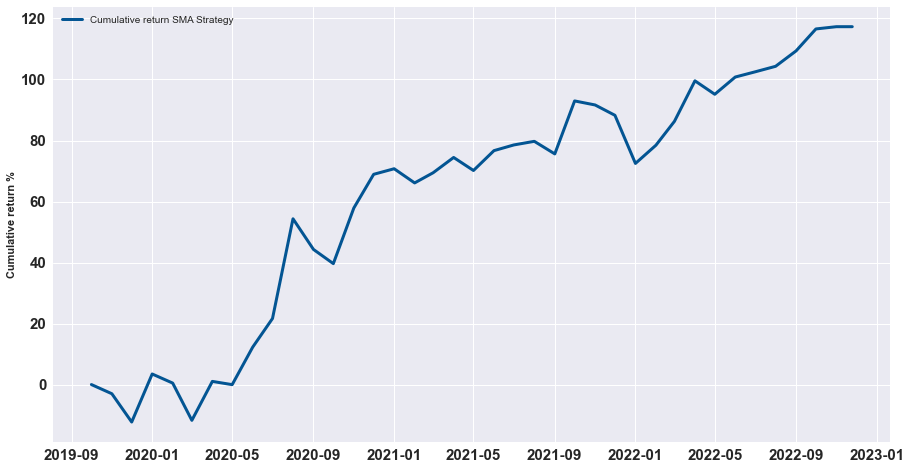

In [11]:
returns = test_set[[f"profit {columns[i]}" \
        for i in range(len(columns))]].sum(axis=1) .cumsum()*100/3

plt.figure(figsize=(15,8))
plt.plot(returns, color="#035593", linewidth=3)
plt.ylabel("Cumulative return %",fontweight="bold")
plt.legend(["Cumulative return SMA Strategy"])
plt.xticks(size=15,fontweight="bold")
plt.yticks(size=15,fontweight="bold")
plt.show()

[*********************100%***********************]  1 of 1 completed

    -----------------------------------------------------------------------------
    Beta: -0.448 	 Alpha: 39.92 %	     Sharpe: 1.116 	 Sortino: 2.402
  -----------------------------------------------------------------------------
    VaR: 39.27 %	 cVaR: 50.84 % 	     VaR/cVaR: 1.295 	 drawdown: 19.71 %
  -----------------------------------------------------------------------------


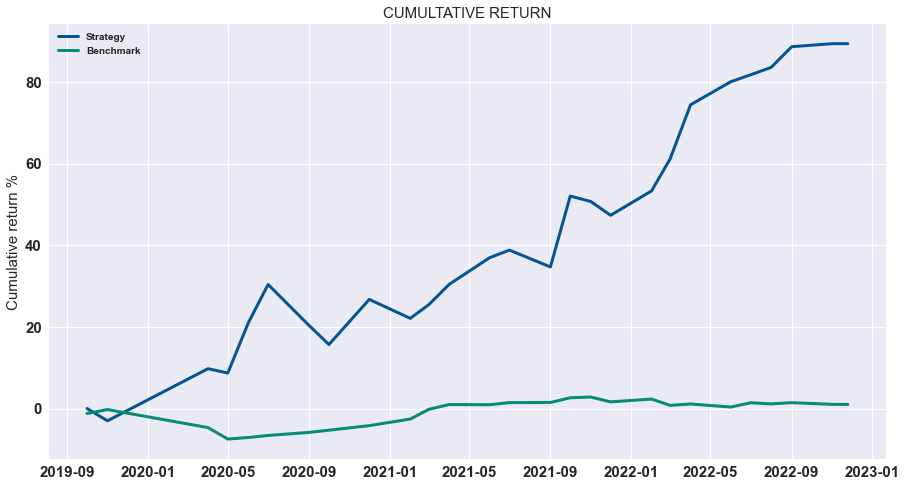

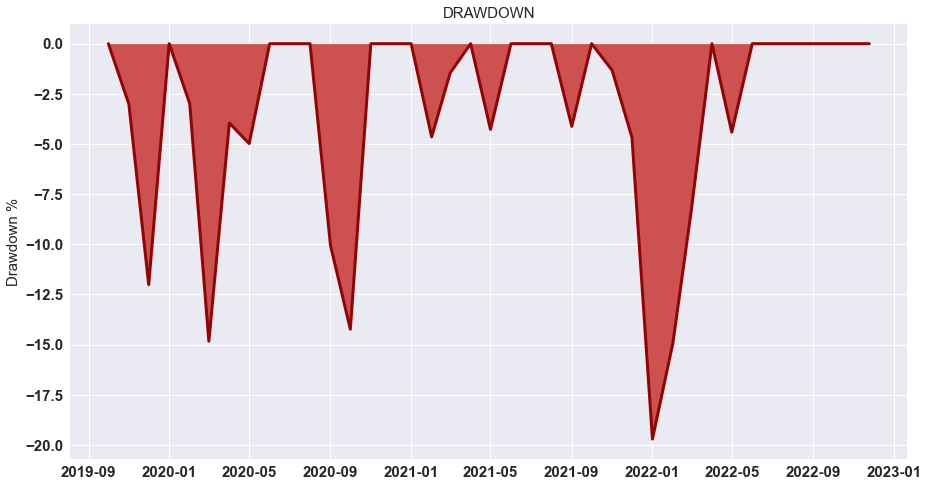

In [12]:
# Code created in the chapter 5
from Backtest import *
pi = (test_set[[f"profit {columns[i]}" for i in range(len(columns))]].sum(axis=1)/3)
backtest_dynamic_portfolio(pi, timeframe=12)

<br>
<br>
<br>



### 4.3.1. Correlation

In [13]:
# Plot absolute price correlation
data[list_tickers].corr()

,META,NFLX,TSLA
META,1.000000,0.935694,0.685834
NFLX,0.935694,1.000000,0.672589
TSLA,0.685834,0.672589,1.000000


In [14]:
# Plot returns correlation
data[list_tickers].pct_change(1).corr()

,META,NFLX,TSLA
META,1.000000,0.270873,0.291586
NFLX,0.270873,1.000000,0.250143
TSLA,0.291586,0.250143,1.000000


<br>

### 4.3.2. Trend return factor

In [15]:
# Our stocks list
list_ = ["TSLA", "GOOG", "META", "NVDA", "PYPL", "CMCSA", "INTC", "NFLX"] 

In [16]:
# We need monthly data now

# Importation of data
database = yf.download(list_, interval="1mo")

# Take only the adjusted stock price
database = database["Adj Close"]

# Drop missing values
data = database.dropna()

#Display the data
data

[*********************100%***********************]  8 of 8 completed


,CMCSA,GOOG,INTC,META,NFLX,NVDA,PYPL,TSLA
Date,,,,,,,,
2015-08-01,24.357021,30.912500,23.036163,89.430000,115.029999,5.446659,35.000000,16.604000
2015-09-01,24.594843,30.421000,24.529707,89.900002,103.260002,5.997554,31.040001,16.559999
2015-10-01,27.076813,35.540501,27.557259,101.970001,108.379997,6.902663,36.009998,13.795333
2015-11-01,26.428305,37.130001,28.297874,104.239998,123.330002,7.717746,35.259998,15.350667
2015-12-01,24.504593,37.944000,28.234932,104.660004,114.379997,8.049899,36.200001,16.000668
...,...,...,...,...,...,...,...,...
2022-08-01,35.870987,109.150002,31.179859,162.929993,223.559998,150.895157,93.440002,275.609985
2022-09-01,29.071459,96.150002,25.426588,135.679993,235.440002,121.353935,86.070000,265.250000
2022-10-01,31.460217,94.660004,28.051140,93.160004,291.880005,134.970001,83.580002,227.539993


In [17]:
# Compute the lookback and hold period
for col in list_:
    data[f"pct+1 {col}"] = data[f"{col}"].pct_change(-1)
    data[f"pct-12 {col}"] = data[f"{col}"].pct_change(12)

# Normalizing the zscore
split = int(0.7*len(data))
train_set = data.iloc[:split,:]
test_set = data.iloc[split:,:]


# Compute the correlation
corr = []
for col in list_:
    cor = train_set[[f"pct-12 {col}", f"pct+1 {col}"]].corr().values[0][1]

    corr.append(cor)

correlation = pd.DataFrame(corr, index=list_, columns=["Corr"])
correlation.sort_values(by="Corr", ascending=False)

,Corr
GOOG,0.283632
INTC,0.273405
PYPL,0.260317
CMCSA,0.200562
META,0.177293
NFLX,0.138330
TSLA,-0.011687
NVDA,-0.127610


<br>

### Build the strategy

In [18]:
best = ["PYPL", "INTC", "GOOG"]

# Find the mean and std vectors
columns = [f"pct-12 {col}" for col in best]
train_set_mean = train_set[columns].mean()
train_set_std = train_set[columns].std()

# Create the zscores
train_set[columns] = (train_set[columns] - train_set_mean) / train_set_std
test_set[columns] = (test_set[columns] - train_set_mean) / train_set_std

# Find the medians
median = train_set[columns].median()

# Compute the signals and the profits
for i in range(len(columns)):

    # Initialize a new column for the signal
    test_set[f"signal {columns[i]}"] = 0

    # Signal is -1 if factor < median
    test_set.loc[test_set[f"{columns[i]}"]<median[i], 
               f"signal {columns[i]}"] = -1

    # Signal is 1 if factor > median
    test_set.loc[test_set[f"{columns[i]}"]>median[i], 
               f"signal {columns[i]}"] = 1


    # Compute the profit
    test_set[f"profit {columns[i]}"] = (test_set[f"signal {columns[i]}"]\
          .shift(1)) * test_set[f"pct+1 {best[i]}"]

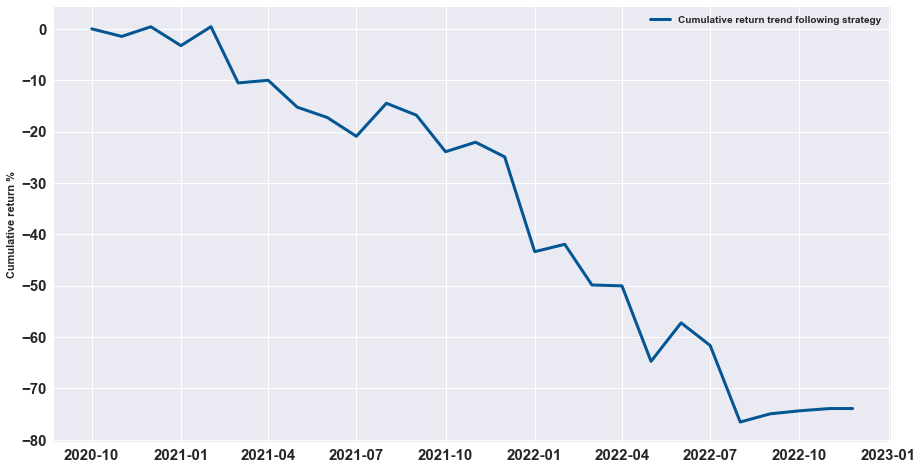

In [19]:
returns = test_set[[f"profit {columns[i]}" \
        for i in range(len(columns))]].sum(axis=1) .cumsum()*100/3

plt.figure(figsize=(15,8))
plt.plot(returns, color="#035593", linewidth=3)
plt.ylabel("Cumulative return %",fontweight="bold")
plt.legend(["Cumulative return trend following strategy"])
plt.xticks(size=15,fontweight="bold")
plt.yticks(size=15,fontweight="bold")
plt.show()

[*********************100%***********************]  1 of 1 completed

    -----------------------------------------------------------------------------
    Beta: -0.209 	 Alpha: -21.57 %	     Sharpe: -1.51 	 Sortino: -1.69
  -----------------------------------------------------------------------------
    VaR: 83.47 %	 cVaR: 90.87 % 	     VaR/cVaR: 1.089 	 drawdown: 56.65 %
  -----------------------------------------------------------------------------


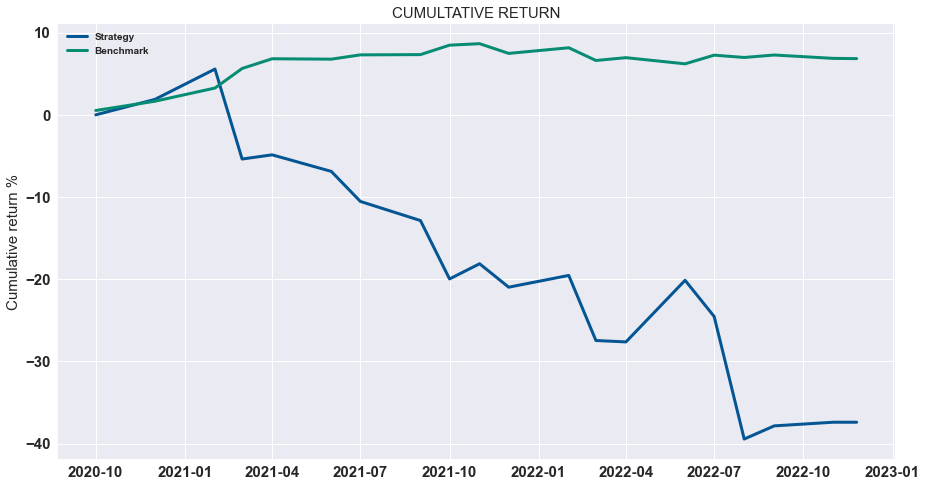

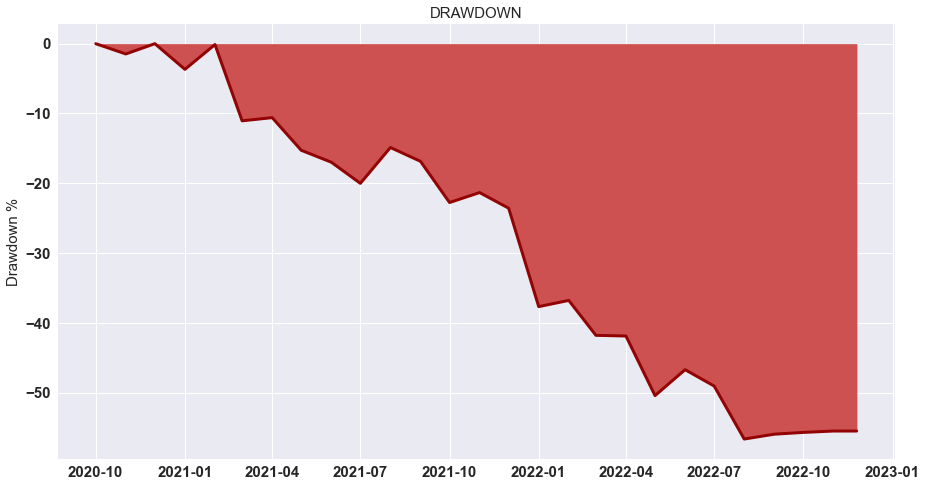

In [20]:
from Backtest import backtest_dynamic_portfolio
pi = (test_set[[f"profit {columns[i]}" for i in range(len(columns))]].sum(axis=1)/3)
backtest_dynamic_portfolio(pi, timeframe=12)